In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/마논스

# !unzip -qq "/content/drive/MyDrive/Colab Notebooks/마논스/img_align_celeba"

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = random.randint(1, 10000)
##########################################################################

#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  8469


- dataroot - 데이터셋 폴더의 경로입니다. 데이터셋에 관한건 다음 섹션에서 더 자세히 설명하겠습니다.

- workers - DataLoader에서 데이터를 불러올 때 사용할 쓰레드의 개수입니다.

- batch_size - 학습에 사용할 배치 크기입니다. DCGAN에서는 128을 사용했습니다.

- image_size - 학습에 사용되는 이미지의 크기입니다. 본 문서에서는 64x64의 크기를 기본으로 하나, 만일 다른 크기의 이미지를 사용한다면 D와 G의 구조 역시 변경되어야 합니다. 

- nc - 입력 이미지의 색 채널개수입니다. RGB 이미지이기 때문에 3으로 설정합니다.

- nz - 잠재공간 벡터의 원소들 개수입니다.

- ngf - 생성자를 통과할때 만들어질 특징 데이터의 채널개수입니다.

- ndf - 구분자를 통과할때 만들어질 특징 데이터의 채널개수입니다.

- num_epochs - 학습시킬 에폭 수입니다. 오래 학습시키는 것이 대부분 좋은 결과를 보이지만, 당연히도 시간이 오래걸리는 것이 단점입니다.

- lr - 모델의 학습률입니다. DCGAN에서 사용된대로 0.0002로 설정합니다.

- beta1 - Adam 옵티마이저에서 사용할 beta1 하이퍼파라미터 값입니다. 역시나 논문에서 사용한대로 0.5로 설정했습니다.

- ngpu - 사용가능한 GPU의 번호입니다. 0으로 두면 CPU에서 학습하고, 0보다 큰 수로 설정하면 각 숫자가 가리키는 GPU로 학습시킵니다.

In [14]:
# 데이터셋의 경로
# dataroot = "/content/drive/MyDrive/Colab Notebooks/마논스/celeba"
# dataloader에서 사용할 쓰레드 수
workers = 2
# 배치 크기 
batch_size = 256
########################################################################
# 이미지의 크기입니다. 모든 이미지들은 transformer를 이용해 64로 크기가 통일됩니다.
image_size = 64
# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 3
# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 200
########################################################################
# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 32
# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 32
# 학습할 에폭 수
num_epochs = 10
########################################################################
# 옵티마이저의 학습률
lr = 0.0002
# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5
# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

https://flonelin.wordpress.com/2020/05/20/%EC%95%88%EC%A0%95%EC%A0%81%EC%9D%B8-generative-adversarial-network-%ED%8A%B8%EB%A0%88%EC%9D%B4%EB%8B%9D%EC%9D%84-%EC%9C%84%ED%95%9C-%ED%8C%81%EB%93%A4/

Files already downloaded and verified


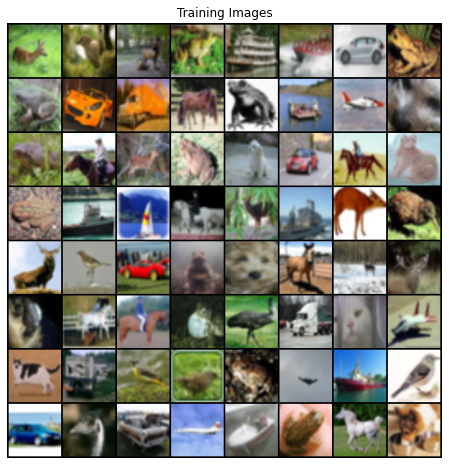

In [15]:
# 우리가 설정한 대로 이미지 데이터셋을 불러와 봅시다
# 먼저 데이터셋을 만듭니다
dataset = dset.CIFAR10(root="./data/CIFAR_10", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               #transforms.CenterCrop(image_size),
                               ###########################################
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [16]:
# netG와 netD에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자

생성자 G 는 잠재 공간 벡터 z 를, 데이터 공간으로 변환시키도록 설계되었습니다.\
우리에게 데이터라 함은 이미지이기 때문에, z 를 데이터공간으로 변환한다는 뜻은, 학습이미지와 같은 사이즈를 가진 RGB 이미지를 생성하는것과 같습니다 (예. 3x64x64). \
실제 모델에서는 스트라이드(stride) 2를 가진 전치 합성곱 계층들을 이어서 구성하는데, 각 전치 합성곱 계층 하나당 2차원 배치 정규화 계층과 relu 활성함수를 한 쌍으로 묶어서 사용합니다. \
**생성자의 마지막 출력 계층에서는 데이터를 tanh 함수에 통과시키는데, 이는 출력 값을 [-1,1] 사이의 범위로 조정**하기 위해서 입니다. 이때 배치 정규화 계층을 주목할 필요가 있는데, DCGAN 논문에 의하면, 이 계층이 경사하강법(gradient-descent)의 흐름에 중요한 영향을 미치는 것으로 알려져 있습니다. 아래의 그림은 DCGAN 논문에서 가져온 생성자의 모델 아키텍쳐입니다.

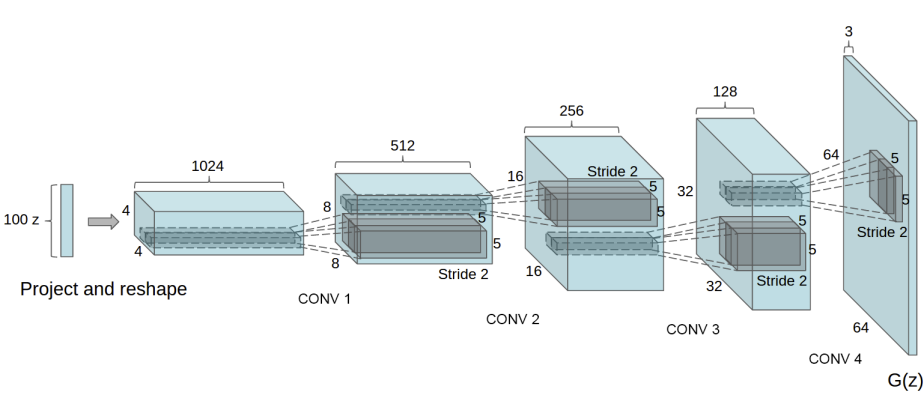

In [17]:
# 생성자 코드

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [18]:
# 생성자를 만듭니다
netG = Generator(ngpu).to(device)

# 필요한 경우 multi-gpu를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# weight_init 함수를 적용시킵니다
netG.apply(weights_init)

# 모델의 구조를 출력합니다
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(200, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 구분자

앞서 언급했듯, 구분자 DD 는 3x64x64 이미지를 입력받아, Conv2d, BatchNorm2d, 그리고 LeakyReLU 계층을 통과시켜 데이터를 가공시키고, 마지막 출력에서 Sigmoid 함수를 이용하여 0~1 사이의 확률값으로 조정합니다. \
이 아키텍쳐는 필요한 경우 더 다양한 레이어를 쌓을 수 있지만, 배치 정규화와 LeakyReLU, 특히 보폭이 있는 (strided) 합성곱 계층을 사용하는 것에는 이유가 있습니다. DCGAN 논문에서는 **보폭이 있는 합성곱 계층을 사용하는 것이 신경망 내에서 스스로의 풀링(Pooling) 함수를 학습**하기 때문에, 데이터를 처리하는 과정에서 **직접적으로 풀링 계층( MaxPool or AvgPooling)을 사용하는 것보다 더 유리**하다고 합니다. 또한 배치 정규화와 leaky relu 함수는 학습과정에서 G 와 D 가 더 효과적인 경사도(gradient)를 얻을 수 있습니다.

In [19]:
# 구분자 코드

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 (nc) x 64 x 64 입니다
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [20]:
# 구분자를 만듭니다
netD = Discriminator(ngpu).to(device)

# 필요한 경우 multi-gpu를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# weight_init 함수를 적용시킵니다
netD.apply(weights_init)

# 모델의 구조를 출력합니다
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Desterministric spatial pooling function(max pooling같은)을 strided convolution으로 바꾸는 것은, network가 스스로 spatial downsampling을 배우도록 한다. 우리는 이런 접근 방법을 generator과 discriminator에서 사용하고 이를 통해서 스스로 spatial upsampling을 배우게 한다.

### 손실함수와 옵티마이저

D 와 G 의 설정을 끝냈으니, 이제 손실함수와 옵티마이저를 정하여 학습을 구체화시킬 시간입니다. 손실함수로는 Binary Cross Entropy loss (BCELoss) 를 사용할겁니다.

참 라벨 (혹은 정답)은 1로 두고, 거짓 라벨 (혹은 오답)은 0으로 두겠습니다.정한 라벨 값들은 추후에 손실값을 계산하는 과정에서 사용될겁니다. 마지막으로, 서로 구분되는 두 옵티마이저를 구성하겠습니다. 하나는 D 를 위한 것, 다른 하나는 G 를 위한 것입니다. \
DCGAN에 서술된 대로, 두 옵티마이저는 모두 Adam을 사용하고, 학습률은 0.0002, Beta1 값은 0.5로 둡니다. 추가적으로, 학습이 진행되는 동안 생성자의 상태를 알아보기 위하여, 프로그램이 끝날때까지 고정된 잠재공간 벡터를 생성하겠습니다 (예. fixed_noise). 이 벡터들 역시 가우시안 분포에서 추출합니다. 학습 과정을 반복하면서 G 에 주기적으로 같은 잠재공간 벡터를 입력하면, 그 출력값을 기반으로 생성자의 상태를 확인 할 수 있습니다.

In [21]:
# BCELoss 함수의 인스턴스를 생성합니다
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
## lr: learning rate 0.001은 너무 높고,0.005는 너무 낮다. 0.0002가 적당
## B1은 0.9에서 트레이닝이 변동성이 크고 불안정, 0.5에서 트레이닝이 안정적

### 학습

#### Part 1 - 구분자의 학습

구분자의 목적은 주어진 입력값이 진짜인지 가짜인지 판별하는 것임을 상기합시다. \
실전적으로 얘기하면, log(D(x)) + log(1-D(G(z))) 를 최대화시키는 것과 같습니다. \
두가지 스텝으로 분리해 계산을 해보겠습니다. \
먼저, 진짜 데이터들로만 이루어진 배치를 만들어 D 에 통과시킵니다. 그 출력값으로 log(D(x) 의 손실값을 계산하고, 역전파 과정에서의 변화도들을 계산합니다. 여기까지가 첫번째 스텝입니다.\
두번째 스텝에서는, 오로지 가짜 데이터들로만 이루어진 배치를 만들어 D 에 통과시키고, 그 출력값으로 log(1-D(G(z))) 의 손실값을 계산해 역전파 변화도를 구하면 됩니다. 이때 두가지 스텝에서 나오는 변화도들은 축적(accumulate) 시켜야 합니다. 변화도까지 구했으니, 이제 옵티마이저를 사용해야겠죠.

#### Part 2 - 생성자의 학습

생성자는 log(1-D(G(z))) 을 최소화시키는 방향으로 학습합니다. 하지만 이 방식은 충분한 변화도를 제공하지 못합니다. 특히 학습초기에는 더욱 문제를 일으키죠. 이를 해결하기 위해 **log(D(G(z))) 를 최대화 하는 방식**으로 바꿔서 학습을 하겠습니다. 

코드에서 구현하기 위해서는 : \
Part 1에서 한대로 구분자를 이용해 생성자의 출력값을 판별해주고, 진짜 라벨값 을 이용해 G의 손실값을 구해줍니다. 그러면 구해진 손실값으로 변화도를 구하고, 최종적으로는 옵티마이저를 이용해 G의 가중치들을 업데이트시켜주면 됩니다. 언뜻 볼때는, 생성자가 만들어낸 가짜 이미지에 진짜 라벨을 사용하는것이 직관적으로 위배가 될테지만, 이렇게 라벨을 바꿈으로써 log(x) 라는 BCELoss의 일부분을 사용할 
수 있게 합니다 

마무리로 G의 훈련 상태를 알아보기 위하여, 몇가지 통계적인 수치들과, fixed_noise를 통과시킨 결과를 화면에 출력하는 코드를 추가하겠습니다.

이때 통계적인 수치들이라 함은 :\
Loss_D - 진짜 데이터와 가짜 데이터들 모두에서 구해진 손실값. \(log(D(x)) + log(1 - D(G(z)))).\
Loss_G - 생성자의 손실값. log(D(G(z)))\
D(x) - 구분자가 데이터를 판별한 확률값입니다. 처음에는 1에 가까운 값이다가, G가 학습할수록 0.5값에 수렴하게 됩니다.\
D(G(z)) - 가짜데이터들에 대한 구분자의 출력값입니다. 처음에는 0에 가까운 값이다가, G가 학습할수록 0.5에 수렴하게 됩니다

결국, 하나의 미니배치 내에서 학습하는 과정은 아래와 같습니다.

1. z를 샘플링해서 Generator G가 가짜 이미지 G(z)를 생성해냅니다.
2. 생성 이미지 G(z)와 실제 이미지 x를 판별자에 통과시켜 예측 값을 반환합니다.
3. 예측 값을 이용해 생성자와 판별자의 loss를 계산합니다.
4. LossG를 이용해 생성자 업데이트
5. LossD를 이용해 판별자 업데이트

In [ ]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
### 겁나 오래 걸림,,,,
### 4시간 30분...
### discriminator에서 loss가 0.0인 것은 실패다.
### generator의 loss가 일정하게 감소할 경우,
### 아마도 discriminator가 garbage image로 인해 잘못되고 있는 것일 수 있다.

Starting Training Loop...
[0/10][0/196]	Loss_D: 1.3012	Loss_G: 1.9289	D(x): 0.4291	D(G(z)): 0.3033 / 0.1656
[0/10][50/196]	Loss_D: 0.0858	Loss_G: 7.4343	D(x): 0.9753	D(G(z)): 0.0577 / 0.0007
[0/10][100/196]	Loss_D: 0.0321	Loss_G: 8.2274	D(x): 0.9899	D(G(z)): 0.0216 / 0.0003
[0/10][150/196]	Loss_D: 0.0265	Loss_G: 7.9015	D(x): 0.9889	D(G(z)): 0.0135 / 0.0004
[1/10][0/196]	Loss_D: 0.0510	Loss_G: 16.4003	D(x): 0.9941	D(G(z)): 0.0438 / 0.0000
[1/10][50/196]	Loss_D: 0.0916	Loss_G: 6.3308	D(x): 0.9523	D(G(z)): 0.0349 / 0.0024
[1/10][100/196]	Loss_D: 0.2119	Loss_G: 5.4173	D(x): 0.9720	D(G(z)): 0.1408 / 0.0079
[1/10][150/196]	Loss_D: 0.0977	Loss_G: 6.9462	D(x): 0.9691	D(G(z)): 0.0600 / 0.0015
[2/10][0/196]	Loss_D: 0.1481	Loss_G: 4.4197	D(x): 0.9136	D(G(z)): 0.0353 / 0.0159
[2/10][50/196]	Loss_D: 0.1690	Loss_G: 4.6666	D(x): 0.8953	D(G(z)): 0.0362 / 0.0163
[2/10][100/196]	Loss_D: 0.7252	Loss_G: 5.2226	D(x): 0.6874	D(G(z)): 0.0014 / 0.0311
[2/10][150/196]	Loss_D: 0.2536	Loss_G: 6.9350	D(x): 0.9624

### 결과

아래는 D와 G의 손실값들을 그래프로 그린 모습입니다



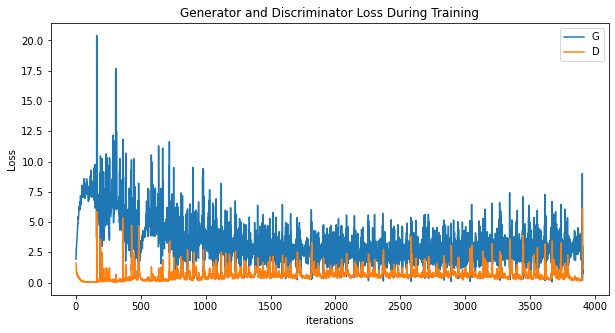

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

G의 학습 과정 시각화

매 에폭마다 fixed_noise를 이용해 생성자가 만들어낸 이미지를 저장한 것을 기억할겁니다. 저장한 이미지들을애니메이션 형식으로 확인해 봅시다. play버튼을 누르면 애니매이션이 실행됩니다

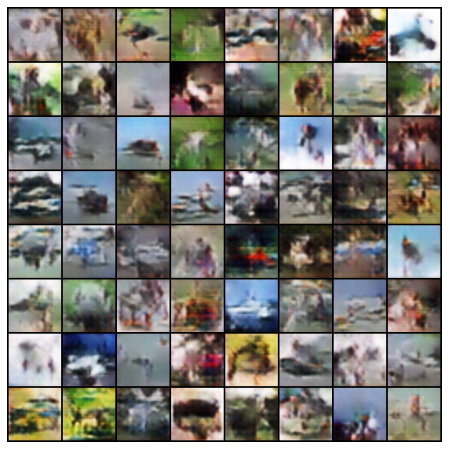

In [12]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

진짜 이미지 vs. 가짜 이미지

진짜 이미지들과 가짜 이미지들을 옆으로 두고 비교를 해봅시다

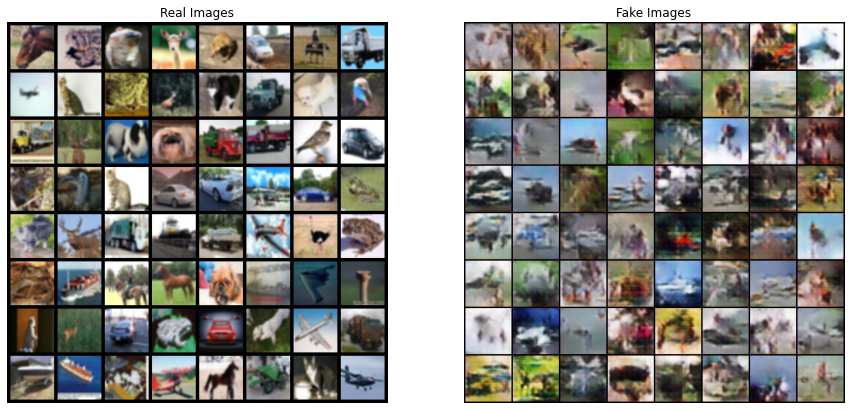

In [13]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(dataloader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()